In [1]:
building_id = 0
price = 400
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 0
price = 300
iteration = 7


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_single.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_single_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Large Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

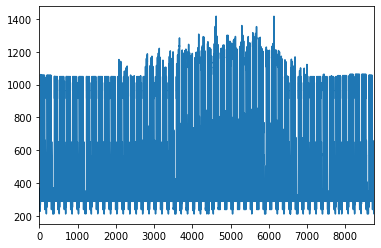

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 178,523.31
1152.5679573158798


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 3,563 m²
Roof area is up 49 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9774646759033203 sec


0.0


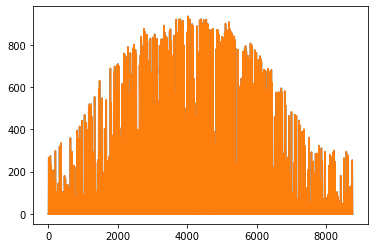

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


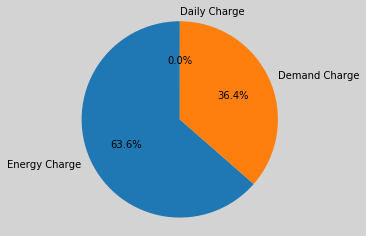

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.roof_percentage()

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%


In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    178523.4
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr        395147.0
Aug        514587.0
Dec        402070.0
Feb        367362.0
Jan        408575.0
Jul        478270.0
Jun        463664.0
Mar        424326.0
May        438232.0
Nov        398329.0
Oct        413882.0
Sep        436953.0
monthly_import    5141397.0
dtype: float64
5141400.0
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
97.5645


In [20]:
my_model.solveResults['solution']['daily_charge_c']

97.5645

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

1

In [23]:
my_model.solveResults['solution']['a150_or_a550']

1

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (155, 235, 225, 26, 56, 16, 0.7999999999999998, 0.25, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.176799774169922 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


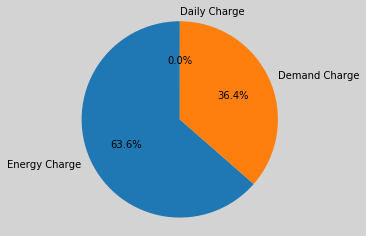

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 240, 225, 36, 41, 26, 0.8499999999999999, 0.5499999999999999, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.065411329269409 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


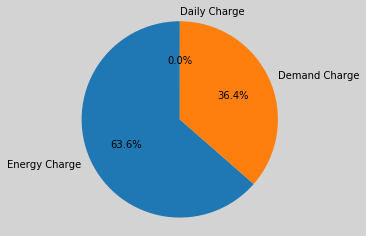

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (260, 255, 200, 21, 26, 26, 0.6499999999999999, 0.8499999999999999, 0.7)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 21.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.330629825592041 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.009765863418579 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


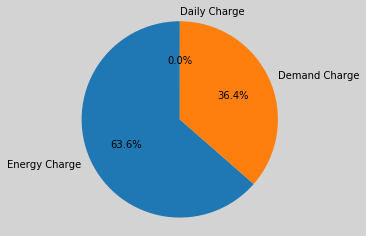

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 260, 180, 11, 11, 41, 0.7, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


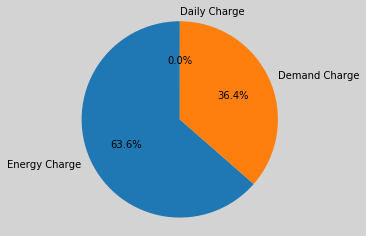

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (240, 95, 220, 16, 6, 11, 0.7, 0.7999999999999998, 0.7)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


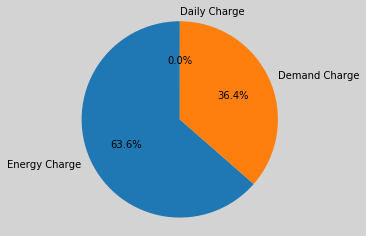

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 190, 205, 46, 11, 36, 0.3, 0.7, 0.44999999999999996)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


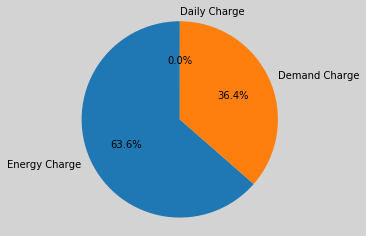

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (210, 130, 140, 41, 21, 16, 0.7, 0.44999999999999996, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


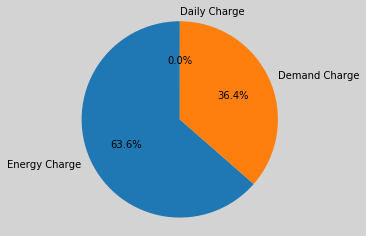

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (115, 265, 140, 21, 51, 41, 0.7499999999999998, 0.3, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


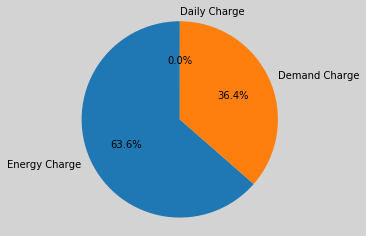

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (170, 185, 170, 31, 16, 16, 0.35, 0.39999999999999997, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.349335670471191 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


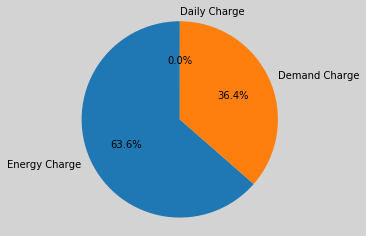

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (230, 230, 215, 51, 21, 31, 0.8999999999999999, 0.44999999999999996, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


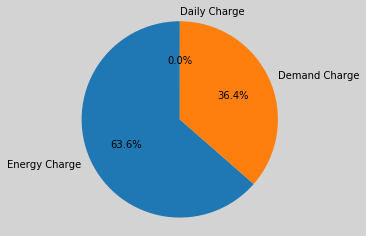

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 255, 220, 11, 16, 51, 0.3, 0.35, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 16.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.023814916610718 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


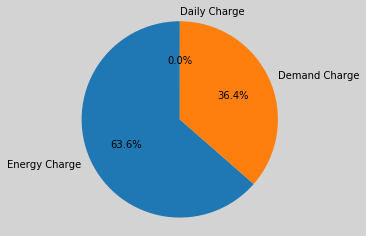

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 175, 115, 6, 46, 51, 0.39999999999999997, 0.6499999999999999, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


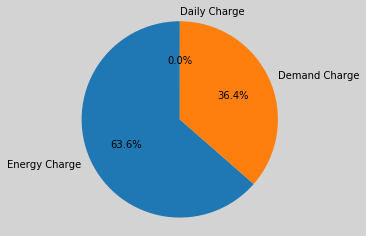

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (105, 200, 155, 46, 56, 11, 0.7, 0.8499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


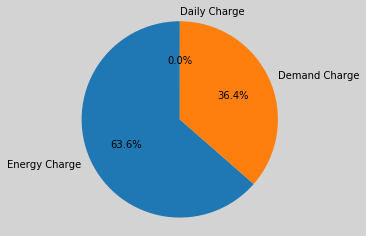

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 150, 110, 46, 51, 26, 0.25, 0.35, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.5120604038238525 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


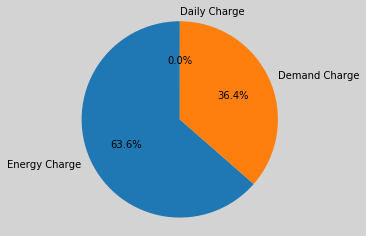

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (205, 205, 135, 46, 56, 6, 0.25, 0.8999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.188571453094482 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


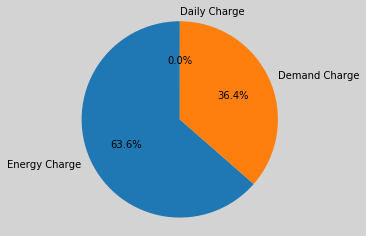

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (245, 155, 120, 6, 21, 51, 0.39999999999999997, 0.6499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (260, 115, 255, 11, 51, 51, 0.44999999999999996, 0.7, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


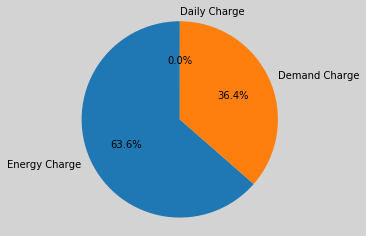

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (230, 235, 100, 51, 6, 16, 0.39999999999999997, 0.44999999999999996, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


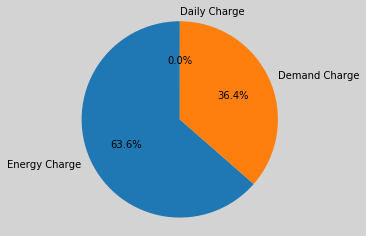

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 235, 215, 21, 31, 21, 0.44999999999999996, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


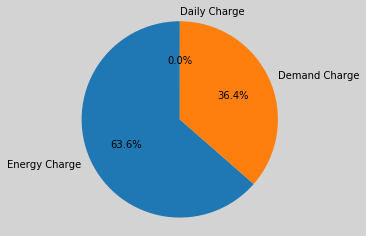

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (240, 225, 150, 51, 31, 31, 0.7999999999999998, 0.3, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.943835735321045 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


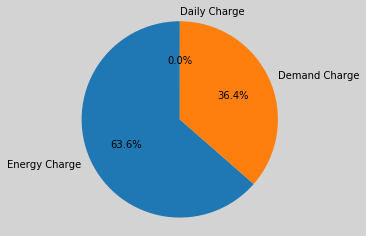

ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (235, 100, 135, 31, 56, 6, 0.5499999999999999, 0.6499999999999999, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.901305675506592 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


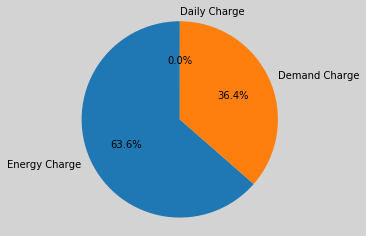

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 250, 120, 6, 51, 26, 0.7, 0.5499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


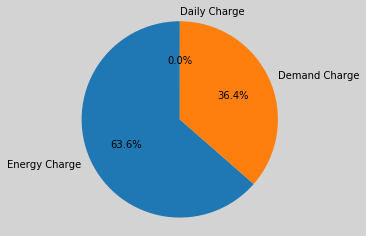

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (125, 115, 240, 1, 16, 46, 0.7999999999999998, 0.2, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 16.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.165566921234131 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


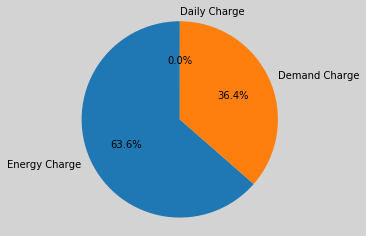

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (260, 170, 180, 16, 16, 56, 0.2, 0.49999999999999994, 0.6499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.158669948577881 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


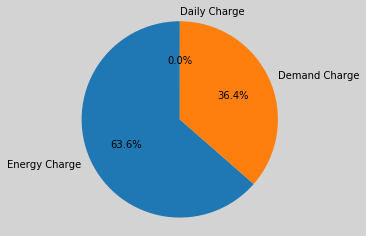

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 245, 175, 21, 51, 26, 0.7999999999999998, 0.35, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.131836652755737 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


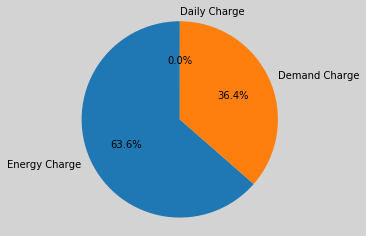

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 100, 130, 41, 26, 36, 0.8999999999999999, 0.8499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


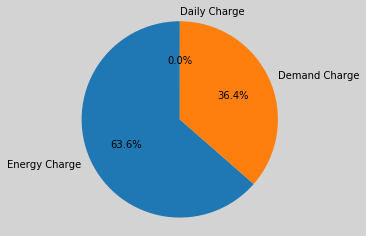

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 155, 240, 16, 21, 6, 0.5499999999999999, 0.7, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (215, 180, 265, 26, 21, 1, 0.3, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


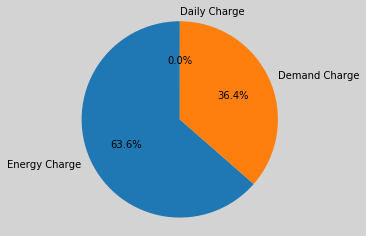

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (90, 175, 255, 31, 26, 31, 0.8999999999999999, 0.5499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


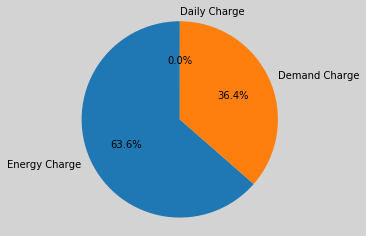

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 95, 130, 31, 46, 56, 0.35, 0.5499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.1993491649627686 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


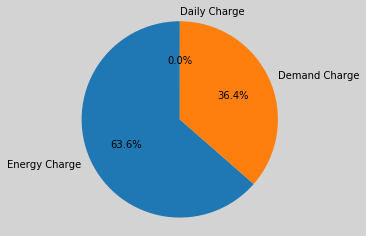

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (190, 155, 150, 6, 1, 21, 0.7, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


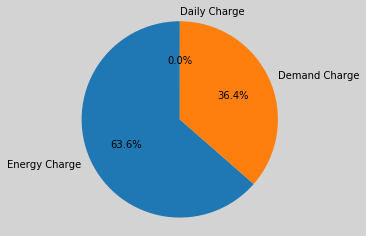

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (195, 230, 220, 51, 51, 16, 0.5999999999999999, 0.49999999999999994, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


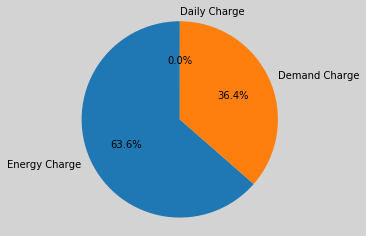

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (140, 220, 235, 36, 16, 21, 0.5499999999999999, 0.25, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


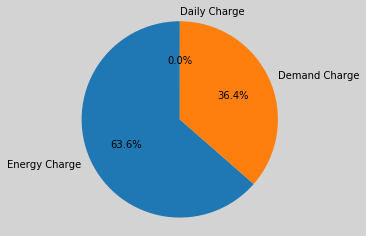

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (210, 95, 175, 6, 56, 21, 0.44999999999999996, 0.8999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 6.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.043291091918945 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.049452304840088 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


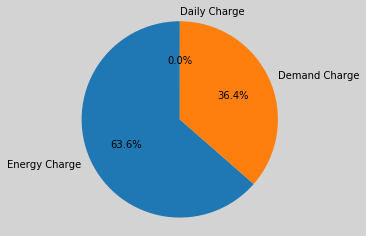

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (95, 105, 200, 36, 1, 26, 0.3, 0.6499999999999999, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 36.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9863901138305664 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 1.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5897793769836426 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


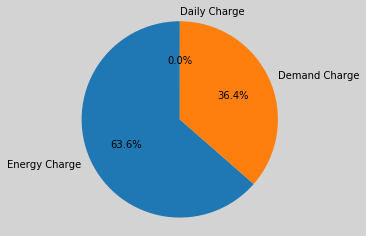

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (250, 230, 140, 36, 56, 16, 0.3, 0.7999999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


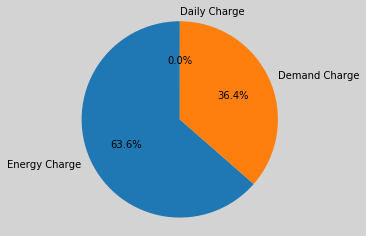

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (150, 220, 230, 51, 16, 31, 0.3, 0.8999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


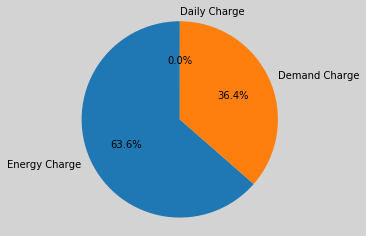

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (185, 220, 150, 41, 16, 11, 0.8499999999999999, 0.7, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9950053691864014 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


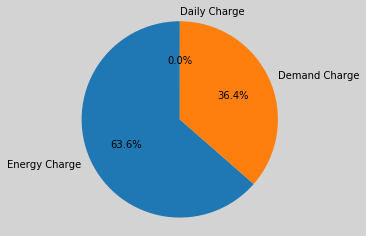

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (205, 180, 205, 1, 21, 26, 0.7999999999999998, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 1.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6560871601104736 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


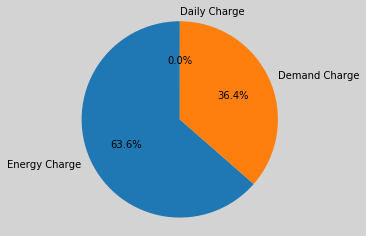

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 195, 235, 51, 6, 1, 0.3, 0.7499999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


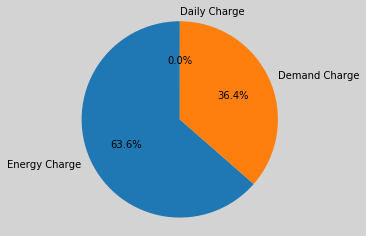

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (95, 260, 245, 21, 46, 46, 0.7999999999999998, 0.44999999999999996, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


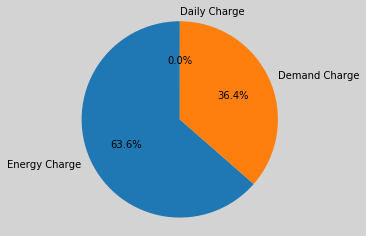

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (155, 100, 125, 46, 1, 31, 0.8999999999999999, 0.39999999999999997, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6309616565704346 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


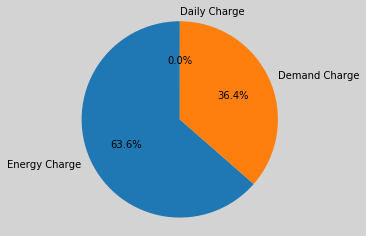

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 235, 245, 31, 51, 36, 0.35, 0.3, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


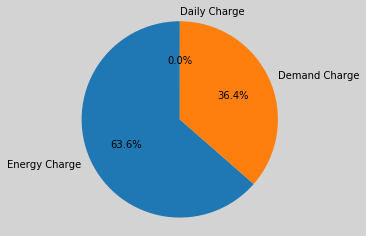

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (145, 170, 145, 1, 41, 6, 0.5999999999999999, 0.49999999999999994, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


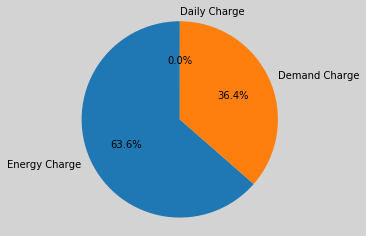

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 250, 140, 11, 46, 26, 0.35, 0.2, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


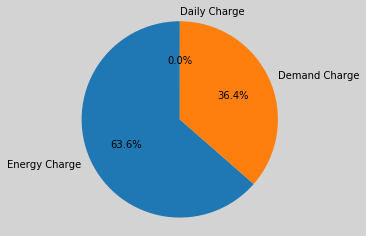

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (165, 155, 150, 56, 31, 46, 0.7, 0.35, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


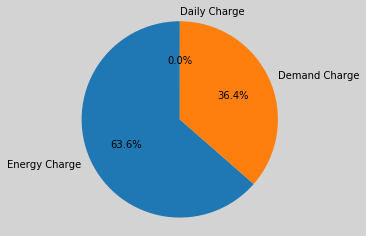

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (260, 230, 235, 41, 26, 6, 0.8499999999999999, 0.8999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2181236743927 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.040194272994995 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


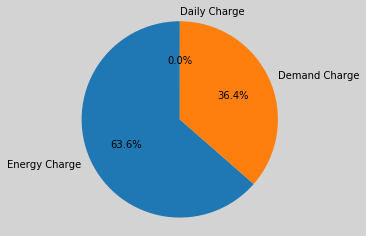

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (90, 125, 90, 31, 6, 51, 0.49999999999999994, 0.5999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


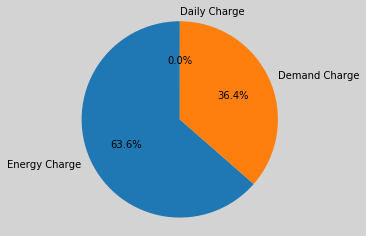

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (105, 120, 205, 16, 1, 16, 0.8999999999999999, 0.6499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 1.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5063116550445557 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.056596755981445 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


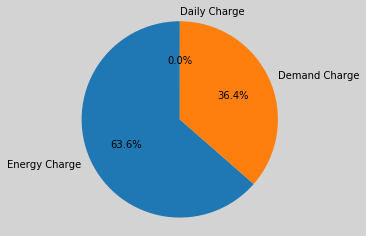

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (95, 125, 210, 41, 46, 56, 0.5999999999999999, 0.7999999999999998, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


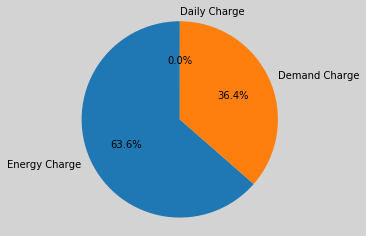

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (220, 195, 90, 26, 1, 11, 0.7, 0.5499999999999999, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2015509605407715 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4136440753936768 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


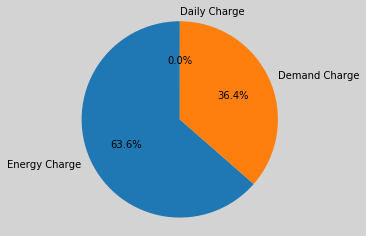

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (240, 165, 215, 41, 41, 21, 0.7499999999999998, 0.7, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 41.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9562160968780518 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


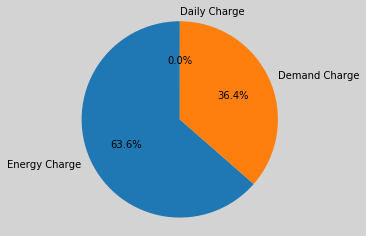

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 120, 265, 6, 36, 11, 0.49999999999999994, 0.25, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


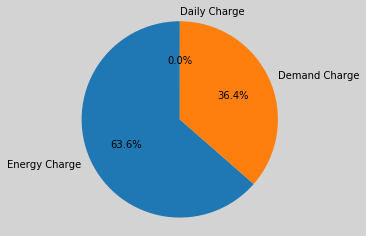

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (180, 250, 140, 16, 41, 26, 0.49999999999999994, 0.7999999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


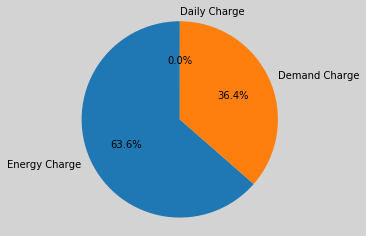

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (105, 170, 195, 56, 56, 56, 0.3, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


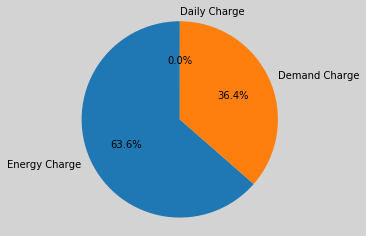

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (255, 225, 110, 21, 56, 36, 0.25, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.49579381942749 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


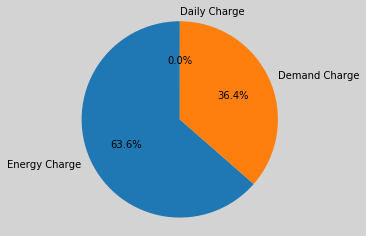

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 155, 125, 26, 36, 41, 0.39999999999999997, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


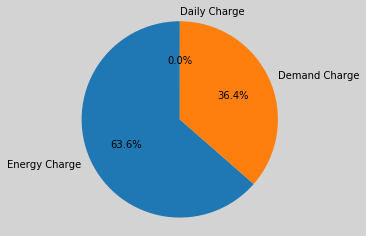

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (205, 135, 215, 31, 21, 21, 0.25, 0.35, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


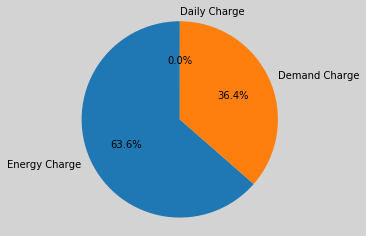

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (235, 150, 145, 26, 31, 6, 0.35, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


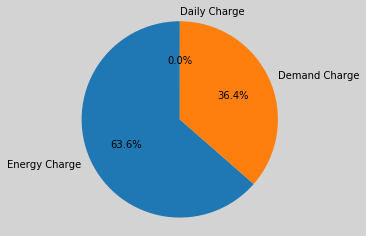

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (150, 100, 195, 11, 1, 16, 0.3, 0.5499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


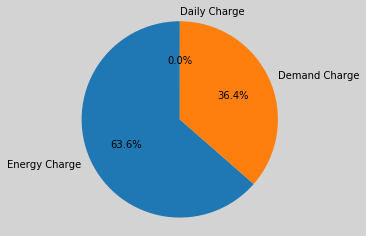

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (260, 160, 200, 6, 31, 36, 0.44999999999999996, 0.25, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.04802393913269 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


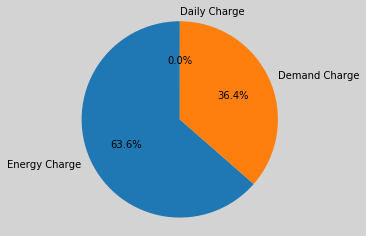

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (90, 95, 90, 36, 11, 56, 0.35, 0.7999999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 36.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.149837970733643 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.017379999160767 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


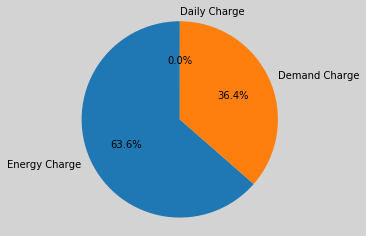

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 225, 185, 56, 51, 41, 0.44999999999999996, 0.39999999999999997, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 56.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.127960443496704 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.083650827407837 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9434080123901367 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


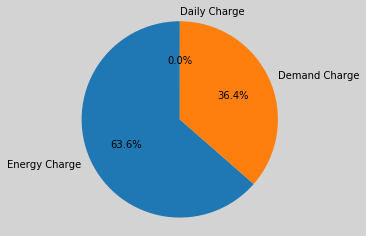

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (185, 260, 130, 16, 36, 21, 0.7, 0.39999999999999997, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.230879306793213 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.666826963424683 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


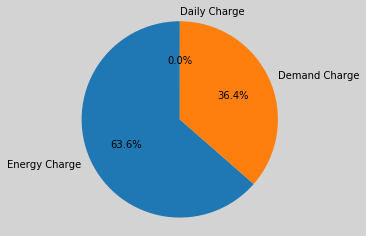

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (200, 170, 255, 6, 51, 6, 0.25, 0.3, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


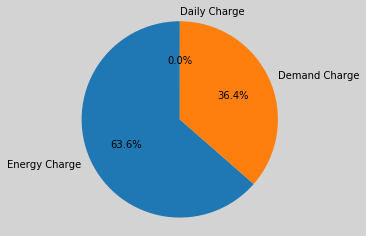

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (95, 210, 245, 51, 1, 46, 0.25, 0.44999999999999996, 0.8499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 1.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.424476146697998 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


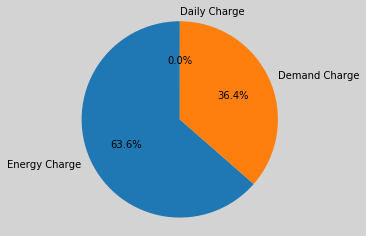

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 145, 265, 21, 1, 16, 0.5999999999999999, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


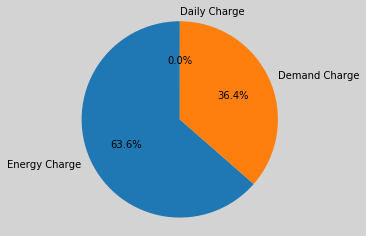

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (110, 90, 210, 21, 31, 26, 0.2, 0.3, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.294376373291016 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.052842140197754 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


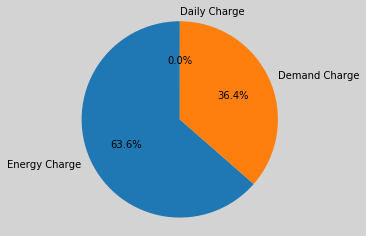

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (210, 130, 250, 51, 21, 1, 0.8499999999999999, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


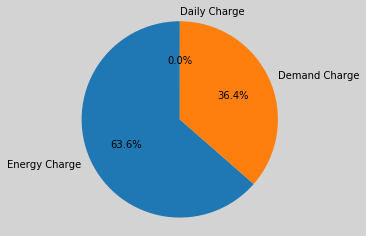

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (150, 210, 250, 31, 21, 46, 0.44999999999999996, 0.8499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.152102947235107 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


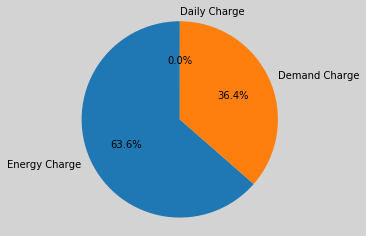

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 240, 200, 51, 56, 51, 0.35, 0.44999999999999996, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (95, 145, 105, 31, 36, 21, 0.35, 0.7, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.932713031768799 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0703840255737305 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


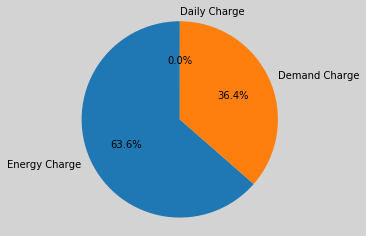

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (150, 140, 245, 16, 36, 16, 0.35, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


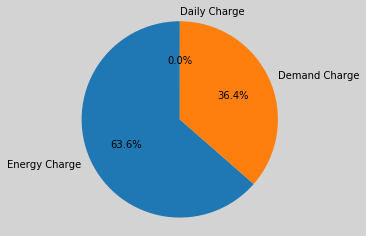

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (230, 210, 200, 11, 36, 51, 0.49999999999999994, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


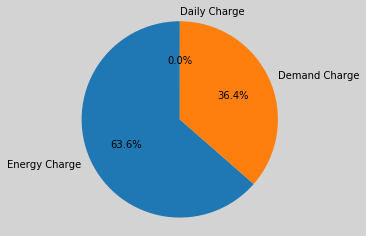

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (155, 225, 235, 41, 31, 56, 0.5999999999999999, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


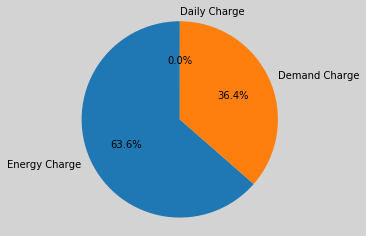

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (90, 100, 135, 41, 26, 26, 0.7, 0.7499999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 41.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9689619541168213 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.882650375366211 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


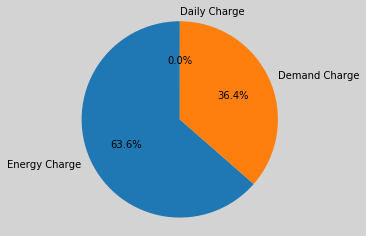

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (125, 195, 180, 1, 16, 51, 0.6499999999999999, 0.8499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


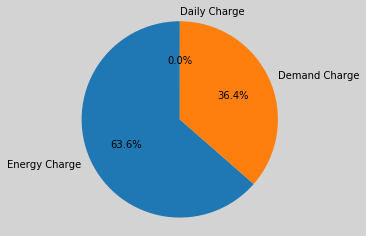

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 160, 170, 1, 6, 36, 0.25, 0.5999999999999999, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.007648944854736 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 1.24301e-09]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


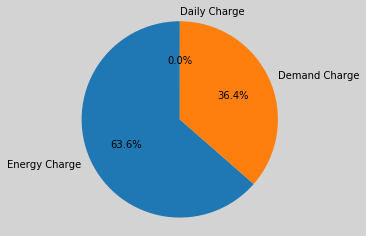

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (140, 160, 200, 36, 56, 51, 0.5499999999999999, 0.7499999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


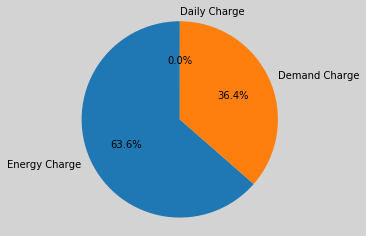

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (125, 110, 200, 41, 46, 51, 0.3, 0.3, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


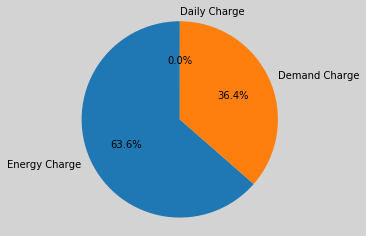

ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (95, 140, 130, 6, 46, 56, 0.2, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.97851300239563 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


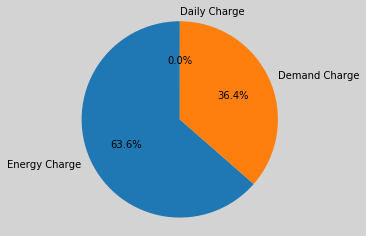

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (175, 215, 105, 16, 31, 16, 0.7999999999999998, 0.25, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 16.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.088913202285767 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (190, 185, 135, 16, 56, 16, 0.8999999999999999, 0.8499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


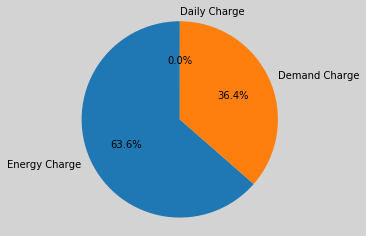

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (135, 145, 185, 16, 36, 21, 0.35, 0.7999999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 16.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.161733150482178 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


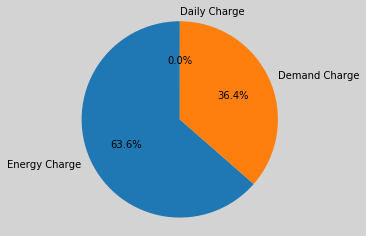

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (170, 265, 105, 11, 31, 46, 0.6499999999999999, 0.7999999999999998, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 46.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.110117673873901 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  96s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


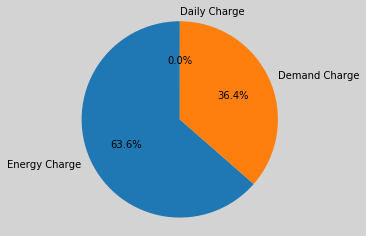

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (225, 185, 135, 26, 41, 36, 0.25, 0.5499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


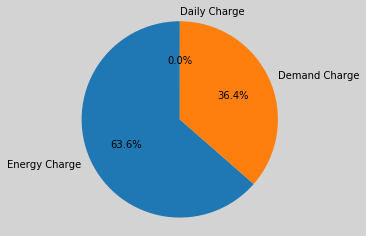

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (250, 160, 145, 56, 56, 6, 0.5999999999999999, 0.7499999999999998, 0.7)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


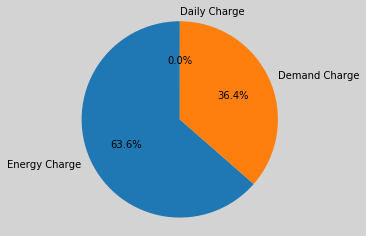

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (115, 265, 215, 6, 1, 21, 0.5499999999999999, 0.39999999999999997, 0.5499999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4940810203552246 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.268705368041992 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


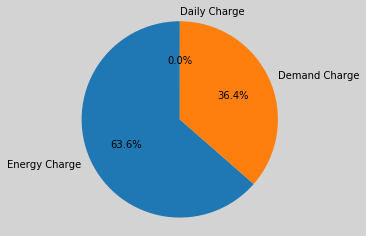

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (265, 100, 105, 46, 11, 31, 0.39999999999999997, 0.2, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.123051404953003 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


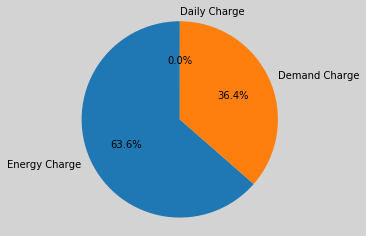

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (105, 140, 95, 11, 26, 11, 0.7499999999999998, 0.5499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9870522022247314 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


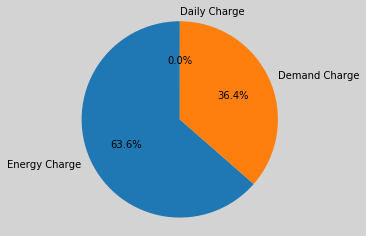

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (210, 175, 240, 1, 26, 56, 0.5999999999999999, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


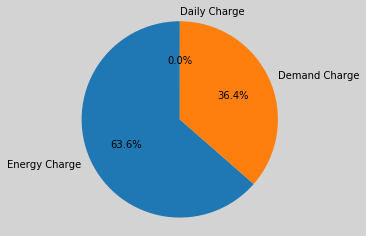

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (265, 240, 185, 41, 26, 26, 0.5499999999999999, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


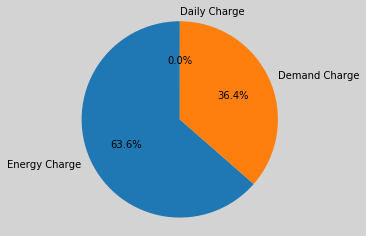

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (100, 100, 245, 51, 31, 21, 0.7999999999999998, 0.6499999999999999, 0.25)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


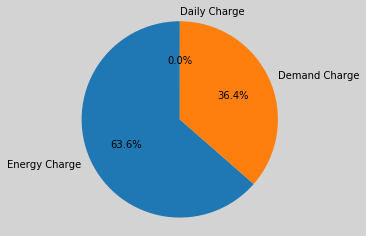

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (170, 170, 95, 51, 36, 11, 0.49999999999999994, 0.8999999999999999, 0.3)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2797980308532715 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.022996425628662 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


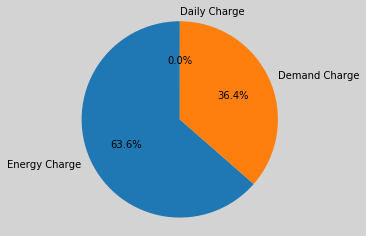

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (205, 160, 115, 51, 36, 36, 0.7999999999999998, 0.5499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 36.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.200159788131714 sec


ERROR:ga_logger:Generated the panel irradiance in   4s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


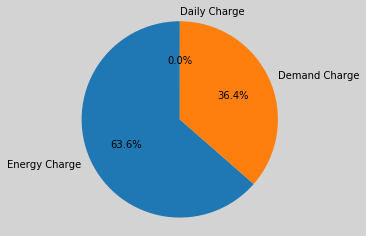

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (130, 225, 220, 51, 51, 51, 0.35, 0.44999999999999996, 0.7999999999999998)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


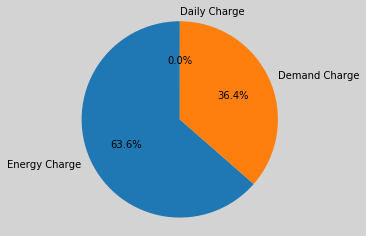

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (155, 230, 125, 26, 41, 21, 0.3, 0.2, 0.35)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.265671968460083 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


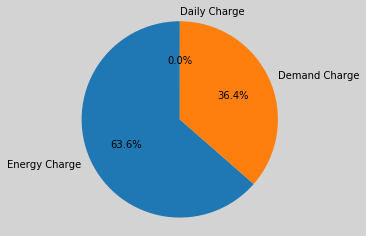

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (265, 185, 200, 6, 21, 41, 0.7, 0.35, 0.7)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


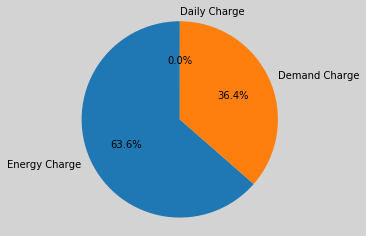

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (185, 115, 185, 51, 36, 11, 0.2, 0.39999999999999997, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.283360719680786 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


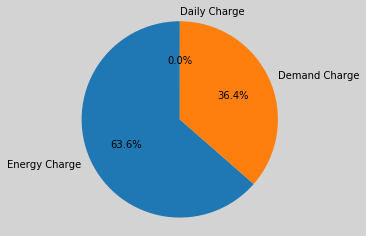

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: (230, 230, 140, 26, 56, 21, 0.35, 0.5999999999999999, 0.2)


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.2281107902526855 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


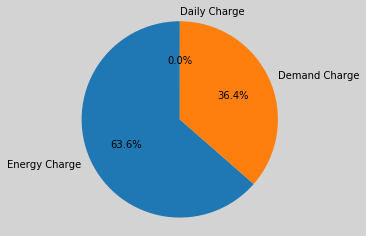

ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 300}


Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
1
The maximum power used is 1,417 kW
The minimum power used is 211 kW
The average power used is 587 kW
The total Electricity use is 5,141,397 kWh or 5,141 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 178,523.31


ERROR:ga_logger:panel values: azi0       95
azi1      140
azi2      130
tilt0       6
tilt1      46
tilt2      56
gcr0      0.2
gcr1     0.25
gcr2      0.9
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 300


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 490190.0


ERROR:ga_logger:total demand cost: 178523.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 5,141,400 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 490,190 per year


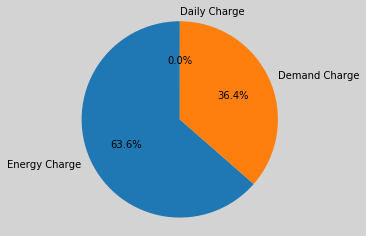

Total roof area of the  building: 3,563 m²
Total roof area used 0 m²
Percentage: 0.0%
[[95, 140, 130, 6, 46, 56, 0.2, 0.25, 0.8999999999999999, 490190.0, 0.0, 0.0, 0.0, 0.0, 1, 'red', {'Levelized Costs': 0.4355000000291085, 'Energy Charge': 311568.6, 'Demand Charge': 178523.4, 'Daily Charge': 97.5645}, 0.0, 5141400.0, 0.0]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","SINGLE")
pvoptimizer.processGA(ga_proc)